In [46]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import cmweather
import glob

In [43]:
radar = ["KARX", "KDVN", "KFSD", "KOAX", "KDMX"]

wind_data = {}

In [55]:
derecho_list = ["20090618", "20100601", "20100718", "20110711", "20130624",
                "20140630", "20140701", "20180628", "20200810", "20211215",
                "20220705", "20230629", "20240524", "20240715"]
date = "20240524"

In [ ]:
for rad in radar:
    try:
        print(glob.glob('/lcrc/group/earthscience/rjackson/Earnest/wind_product/%s/%s%s*.nc' %
                                  (rad, rad, date)))
        wind_data[rad] = xr.open_mfdataset('/lcrc/group/earthscience/rjackson/Earnest/wind_product/%s/%s%s*.nc' %
                                  (rad, rad, date))
    except OSError:
        if rad in wind_data.keys():
            del wind_data[rad]
        continue
    wind_data[rad]["range"] = np.sqrt(wind_data[rad]["x"]**2 + wind_data[rad]["y"]**2)
    
    # Mask out cross-wind component and restrict to 10 km range 
    inds = np.logical_and(wind_data[rad]["reflectivity"] > 0,
                          np.abs(wind_data[rad]["corrected_velocity_region_based"]) > 2)
    mask = np.logical_and(wind_data[rad]["range"] < 10000., inds)
    wind_data[rad]["dir"] = np.rad2deg(np.arctan2(-wind_data[rad]["u"], -wind_data[rad]["v"]))
    wind_data[rad]["dir"] = xr.where(wind_data[rad]["dir"] < 0, wind_data[rad]["dir"] + 360,
                                     wind_data[rad]["dir"])
    wind_data[rad]["azimuth"] = np.rad2deg(np.arctan2(wind_data[rad]["x"], wind_data[rad]["y"]))
    wind_data[rad]["azimuth"] = xr.where(wind_data[rad]["azimuth"] < 0, wind_data[rad]["azimuth"] + 360,
                                     wind_data[rad]["azimuth"])
    # Apply bias correction
    #a = 0.9
    #b = 6.07
    #wind_data[rad]["spd"] = wind_data[rad]["spd"].where(inds)
    #wind_data[rad]["spd"] = wind_data[rad]["spd"] / a - b

['/lcrc/group/earthscience/rjackson/Earnest/wind_product/KARX/KARX20240524_134753_V06.nc.radar.nc', '/lcrc/group/earthscience/rjackson/Earnest/wind_product/KARX/KARX20240524_231730_V06.nc.radar.nc', '/lcrc/group/earthscience/rjackson/Earnest/wind_product/KARX/KARX20240524_102541_V06.nc.radar.nc', '/lcrc/group/earthscience/rjackson/Earnest/wind_product/KARX/KARX20240524_094914_V06.nc.radar.nc', '/lcrc/group/earthscience/rjackson/Earnest/wind_product/KARX/KARX20240524_232205_V06.nc.radar.nc', '/lcrc/group/earthscience/rjackson/Earnest/wind_product/KARX/KARX20240524_184927_V06.nc.radar.nc', '/lcrc/group/earthscience/rjackson/Earnest/wind_product/KARX/KARX20240524_091022_V06.nc.radar.nc', '/lcrc/group/earthscience/rjackson/Earnest/wind_product/KARX/KARX20240524_093924_V06.nc.radar.nc', '/lcrc/group/earthscience/rjackson/Earnest/wind_product/KARX/KARX20240524_125156_V06.nc.radar.nc', '/lcrc/group/earthscience/rjackson/Earnest/wind_product/KARX/KARX20240524_230344_V06.nc.radar.nc', '/lcrc/gr

In [48]:
wind_data.keys()

dict_keys(['KARX', 'KDVN', 'KFSD', 'KOAX'])

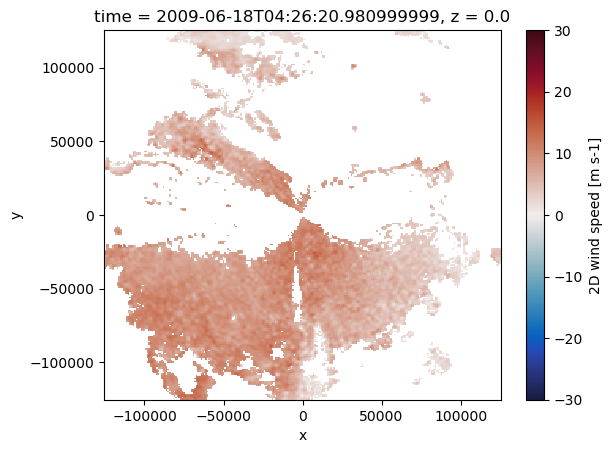

In [37]:
def between_two_values(var, x, y):
    return np.logical_and(var >= x, var <= y)
tolerance = 60.

mask = wind_data["KDVN"]["corrected_velocity_unravel"] > -9999.
mask = np.logical_and(mask, ~between_two_values(np.abs(
    wind_data["KDVN"]["dir"] - wind_data["KDVN"]["azimuth"]), 90-tolerance, 90+tolerance))
mask = np.logical_and(mask,  
    ~between_two_values(np.abs(
    wind_data["KDVN"]["dir"] - wind_data["KDVN"]["azimuth"]), 270-tolerance, 270+tolerance))
wind_data["KDVN"]["spd"].where(mask).isel(time=6, z=0).plot(cmap='balance', vmin=-30, vmax=30)

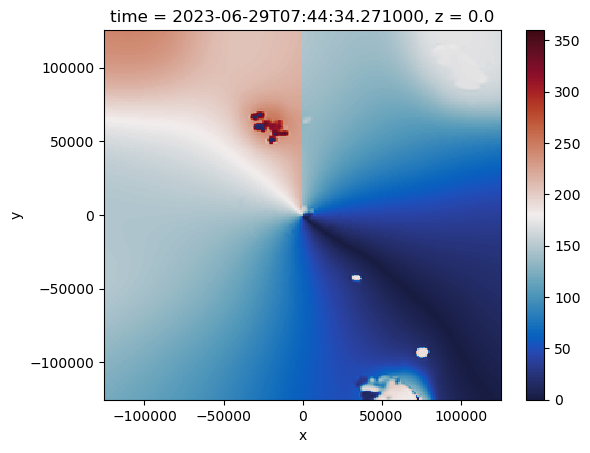

In [31]:
np.abs(wind_data["KDVN"]["dir"] - wind_data["KDVN"]["azimuth"]).isel(time=6, z=0).plot(vmin=0, vmax=360, cmap='balance')

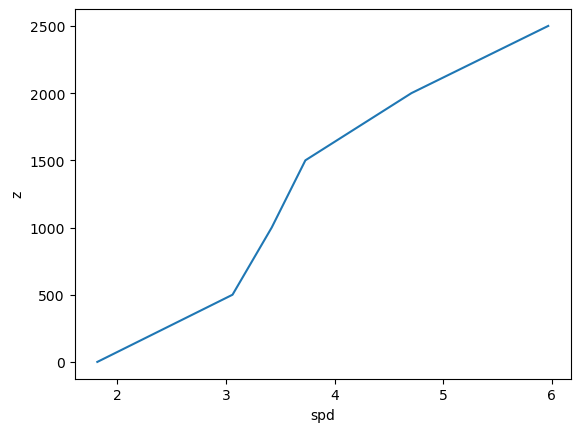

In [38]:
wind_data["KDMX"]["spd"].mean(dim=['x', 'y', 'time']).plot(y='z')

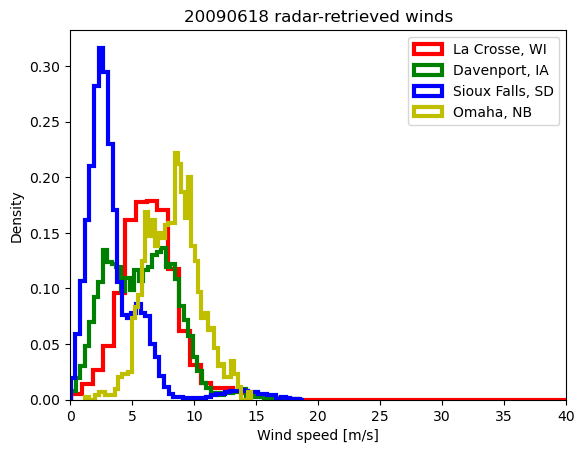

In [49]:
rad_names = {'KARX': 'La Crosse, WI', 'KDVN': 'Davenport, IA', 
             'KFSD': 'Sioux Falls, SD', 'KOAX': 'Omaha, NB',
             'KDMX': 'Des Moines, IA'}
colors = ['r', 'g', 'b', 'y', 'k']
winds_rad = {}
for i, rad in enumerate(radar):
    if not rad in wind_data.keys():
        continue
    try:
        mask = wind_data[rad]["corrected_velocity_unravel"] > -9999.
        mask = np.logical_and(mask, wind_data[rad]["range"] < 10000.)
        mask = np.logical_and(mask, ~between_two_values(np.abs(
            wind_data[rad]["dir"] - wind_data[rad]["azimuth"]), 90-tolerance, 90+tolerance))
        mask = np.logical_and(mask,  
            ~between_two_values(np.abs(
            wind_data[rad]["dir"] - wind_data[rad]["azimuth"]), 270-tolerance, 270+tolerance))
        plt.hist(wind_data[rad]["spd"].where(mask).isel(z=0).values.flatten(), bins=50, 
                 histtype='step', density=True, label=rad_names[rad],
                 linewidth=3, color=colors[i])
        winds_rad[rad] = wind_data[rad]["spd"].where(mask).isel(z=0)
    except KeyError:
        continue

plt.legend()
plt.xlabel('Wind speed [m/s]')
plt.ylabel('Density')
plt.xlim([0, 40])
plt.title(f"{date} radar-retrieved winds")
plt.savefig(f"pdf_{date}.png")

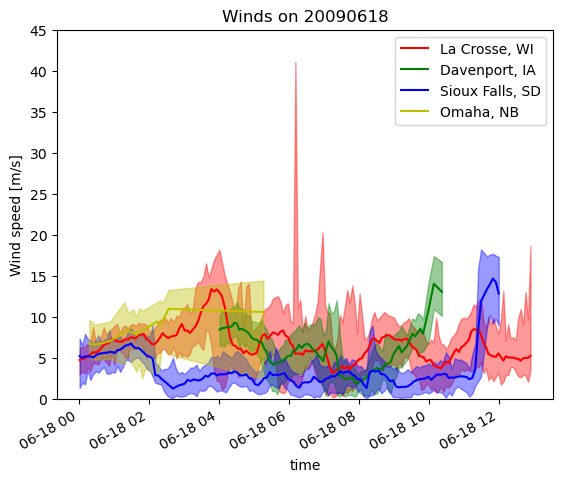

In [51]:
for i, rad in enumerate(radar):
    if not rad in winds_rad.keys():
        continue
    try:
        winds_rad[rad].median(dim=['x', 'y']).plot(label=rad_names[rad], color=colors[i])
        first_percentile = winds_rad[rad].chunk(dict(y=-1, x=-1)).quantile(.01, dim=['x', 'y']).values
        ninety_ninth_percentile = winds_rad[rad].chunk(dict(y=-1, x=-1)).quantile(.99, dim=['x', 'y']).values
        plt.fill_between(winds_rad[rad].time, first_percentile, ninety_ninth_percentile,
                        color=colors[i], alpha=0.4)
    except KeyError:
        continue
plt.ylabel("Wind speed [m/s]")
plt.ylim([0, 45])
plt.legend()
plt.title(f"Winds on {date}")
plt.savefig(f'pdf_time_series_{date}.png')

/gpfs/fs1/home/rjackson/mambaforge/envs/pydda_env/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


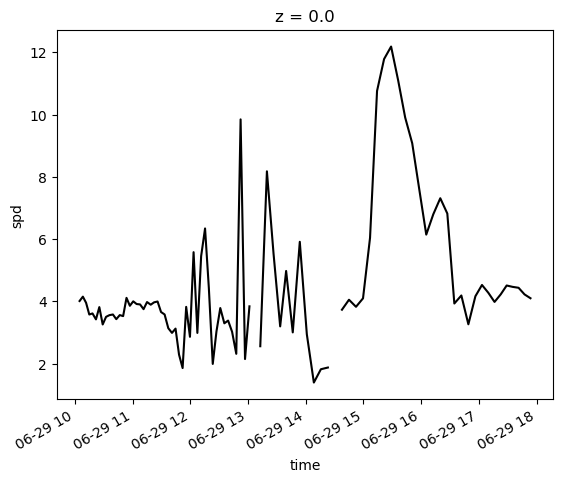

In [42]:
 winds_rad[rad].median(dim=['x', 'y']).plot(label=rad_names[rad], color=colors[i])

In [ ]:
rad = "KARX"
wind_bins = np.linspace(0, 40, 50)
for t in range(winds_rad[rad].sizes["time"]):
